# SVHN Projektarbeit

# Experiment

## wichtige Pakete einlesen

gegebenenfalls müssen die Pakete (v.a. im Jupyter Hub) zunächst installiert werden, bevor sie importiert werden können

In [111]:
!pip install scipy
!pip install torchvision
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install torchsummary
!pip install pandas
!pip install seaborn

In [2]:
import torch                # PyTorch: das Hauptframework für Deep Learning (Tensors, Autograd, Modelle, Training)
import torchvision          # TorchVision: Bibliothek mit Standard-Datasets, Modellen und Bildtransformationen
import torch.nn as nn       # nn = Neural Network Module: für das Erstellen von Layern (z.B. Conv2d, Linear, ReLU)
import torch.nn.functional as F  # Funktionale API: für direkte Nutzung von Aktivierungsfunktionen, Losses, etc. (z.B. F.relu)
import torch.optim as optim       # Optimizer (z.B. SGD, Adam) für das Training von Modellen
import matplotlib.pyplot as plt   # Matplotlib: zum Plotten von Bildern, Trainingskurven oder Loss/Accuracy
import random                     # Python Standardbibliothek: für zufällige Zahlen, Shuffling, Seed-Kontrolle
import scipy.io                   # SciPy I/O: um .mat-Dateien (MATLAB-Format) zu laden, z.B. deine train/test Daten
from torch.utils.data import Dataset, DataLoader
                                  # Dataset: Basisklasse für eigene Datensätze
                                  # DataLoader: erleichtert Batch-Verarbeitung, Shuffling und Parallelisierung beim Training
import torchvision.transforms as transforms
                                  # Transformations für Bilder: z.B. Normalisierung, Resizing, RandomCrop, ToTensor
import os                         # Zugriff auf Betriebssystemfunktionen (Dateien, Verzeichnisse)
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix
from torchsummary import summary
import pandas as pd



## Daten

### Daten über torchvision

Für unseren Datensatz gibt es zwei Wege die Daten sinnvoll im Notebook zu hinterlegen. Tatsächlich gibt es diesen Datensatz im Paket torchvision und kann direkt per Code heruntergeladen werden. Das ist vor allem dann sinnvoll, wenn der Datensatz auf dem lokalen Gerät nicht zur Verfügung steht. Es bietet aber außerdem den Vorteil, dass man damit besser über github arbeiten kann, da dort die Daten über 100MB nicht hochgeladen werden können. Zur Vollständigkeit ist aber dennoch der Code zum einlesen der Daten darunter.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Train-Set
train_dataset = datasets.SVHN(
    root="data",
    split='train',      # 'train' = train_32x32.mat
    download=True,      # lädt automatisch herunter, wenn nicht vorhanden
    transform=transform
)

# Test-Set
test_dataset = datasets.SVHN(
    root="data",
    split='test',       # 'test' = test_32x32.mat
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


100.0%
100.0%


### Daten über seine eigene os

In dieser Zelle wird eine **PyTorch Dataset-Klasse** für den SVHN-Datensatz definiert.

- **Zweck:** Ermöglicht es, `.mat`-Dateien mit Bildern und Labels einfach in PyTorch zu laden und in Batches zu verarbeiten.
- **Funktionen:**
  - `__init__`: Lädt die Daten aus der `.mat`-Datei und speichert optionale Transformationen.
  - `__len__`: Gibt die Anzahl der Bilder zurück (wichtig für DataLoader).
  - `__getitem__`: Liefert ein einzelnes Bild und Label als Tensor, normalisiert die Pixel und wendet Transformationen an.
- **Besonderheiten:**
  - Pixelwerte werden von [0,255] auf [0,1] normalisiert.
  - SVHN Label „10“ wird in `0` umgewandelt.
  - PyTorch erwartet die Kanal-Reihenfolge `(C,H,W)`, daher wird das Bild umgeformt.


In [116]:
class SVHNDataset(Dataset):
    # Wir erben von torch.utils.data.Dataset, damit PyTorch den DataLoader nutzen kann

    def __init__(self, mat_file, transform=None):
        # Konstruktor: Lädt die .mat-Datei und initialisiert Variablen
        data = scipy.io.loadmat(mat_file)   # scipy.io.loadmat: lädt MATLAB-Dateien
        self.X = data['X']                  # X enthält die Bilder: shape (32, 32, 3, N)
        self.y = data['y'].flatten()        # y enthält Labels: shape (N,). flatten() macht aus Spaltenvektor 1D-Array
        self.transform = transform          # Transformationsobjekt für Bildvorverarbeitung (optional)

        # SVHN-Spezialfall: Label "10" bedeutet Ziffer "0"
        self.y[self.y == 10] = 0

    def __len__(self):
        # Gibt die Anzahl der Samples zurück, damit DataLoader weiß, wie viele es gibt
        return self.X.shape[3]              # N = Anzahl Bilder

    def __getitem__(self, idx):
        # Liefert ein einzelnes Sample (Bild + Label) für Index idx
        img = self.X[:,:,:,idx]             # Bild: (32,32,3)
        # torch.tensor: konvertiert numpy-array zu Tensor
        # permute(2,0,1): PyTorch erwartet Kanal zuerst (C,H,W) statt H,W,C
        # float()/255.0: normalisiert Pixelwerte von [0,255] auf [0,1]
        img = torch.tensor(img).permute(2,0,1).float()/255.0
        label = int(self.y[idx])            # Label als Integer

        if self.transform:
            img = self.transform(img)       # Falls Transform gesetzt, anwenden (z.B. RandomCrop, Normalize)

        return img, label                     # Rückgabe: Tensorbild + Label


In [ ]:
transform = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

train_dataset = SVHNDataset('train_32x32.mat', transform=transform)
test_dataset  = SVHNDataset('test_32x32.mat',  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


### Beispiel der Trainingsdaten


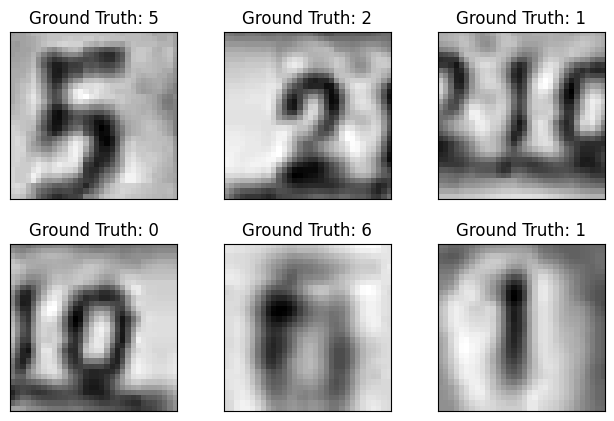

In [7]:
# Iterator über den Test-DataLoader erstellen
examples = enumerate(test_loader)

# Den ersten Batch aus dem Test-DataLoader holen
batch_idx, (example_data, example_targets) = next(examples)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# 6 Bilder aus dem Batch plotten
for i in range(6):
    # Unterteilt die Figur in 2x3 Raster, i+1 = aktuelle Position
    plt.subplot(2, 3, i+1)
    plt.tight_layout()  # Sorgt dafür, dass Plots sich nicht überlappen
    # Zeige das Bild an; example_data[i][0] = 1. Kanal (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    # Titel mit Ground-Truth-Label
    plt.title("Ground Truth: {}".format(example_targets[i]))
    # Achsenbeschriftungen entfernen
    plt.xticks([])
    plt.yticks([])

# Alle geplotteten Bilder anzeigen
plt.show()


## klassisches neuronales Netz

### Definition des CNN-Modells

In dieser Zelle wird die Klasse `Net` definiert, die ein Convolutional Neural Network (CNN) implementiert.

- **Zweck:** Definiert die Architektur des neuronalen Netzes für Bilderkennung.
- **Aufbau:**
  1. Convolutional Layer (Feature Extraction)
  2. Max-Pooling (Reduzierung der Dimensionen)
  3. ReLU (Nichtlinearität)
  4. Dropout (Regularisierung)
  5. Flatten (Umwandlung in 1D für Fully Connected Layer)
  6. Fully Connected Layer(s) (klassische Klassifizierung)
  7. Softmax (Wahrscheinlichkeitsausgabe für Klassen)
- **TODO-Liste im Kommentar:** Zeigt, welche Layer du für ein vollständiges CNN einbauen solltest.


In [11]:
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)

# CNN-Klasse definieren
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- Erster Convolutional Layer ---
        # nn.Conv2d: 2D Convolution
        # 3 Input-Kanäle (RGB), 10 Output-Kanäle (Features), Kernelgröße 5x5
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)  # TODO: ggf. auf 1 Input-Kanal anpassen für Graustufen

        # Dropout für die Convolutionen (reduziert Overfitting)
        self.drop = nn.Dropout2d()

        # Fully Connected Layer
        # nn.Linear: verbindet alle Eingangseinheiten mit allen Ausgangseinheiten
        # 1960 Eingangsdimensionen → 1000 Ausgangsdimensionen (muss evtl. an tatsächliche Flatten-Größe angepasst werden)
        self.fc1 = nn.Linear(1960, 1000)

    # --- Forward-Pass ---
    def forward(self, x):
        x = self.conv1(x)               # 1. Convolution
        x = self.drop(x)                # 2. Dropout
        x = F.max_pool2d(x, 2)          # 3. Max-Pooling über 2x2
        x = F.relu(x)                   # 4. ReLU-Aktivierung
        x = x.flatten(1)                # 5. Flattening: CxHxW → 1D für Fully Connected Layer
        x = self.fc1(x)                 # 6. Fully Connected Layer
        x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe
        return x                        # Rückgabe: Log-Wahrscheinlichkeiten pro Klasse

In [12]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

### Initialisierung des Modells, der Gewichte und des Optimizers

In dieser Zelle wird das neuronale Netz erstellt, seine Gewichte initialisiert und der Optimizer definiert.

- `model = Net()`: Erstellt eine Instanz des zuvor definierten CNN-Modells.
- `model.apply(weights_init)`: Wendet eine eigene Initialisierungsfunktion (`weights_init`) auf alle Layer des Modells an.
  Dies sorgt dafür, dass die Anfangsgewichte der Layer sinnvoll gesetzt werden, was das Lernen stabiler und schneller macht.
- `optim.SGD(...)`: Erstellt einen Stochastic Gradient Descent Optimizer.
  - `model.parameters()`: Übergibt die trainierbaren Parameter des Modells.
  - `lr=0.01`: Lernrate.
  - `momentum=0.5`: Verbessert die Konvergenzgeschwindigkeit, indem vorherige Gradienten berücksichtigt werden.


In [37]:
# Erstellt eine Instanz des CNN-Modells (Klasse Net aus vorheriger Zelle)
model = Net()

# Initialisiert die Gewichte aller Layer mit einer benutzerdefinierten Funktion weights_init
# Dadurch starten die Gewichte nicht zufällig schlecht, was Training verbessern kann
model.apply(weights_init)

# Definiert den Optimizer: Stochastic Gradient Descent
# model.parameters(): alle trainierbaren Parameter des Modells
# lr=0.01: Lernrate
# momentum=0.5: hilft, "Schwankungen" im Gradienten auszugleichen
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


### Trainingsroutine

In dieser Zelle wird die Trainingsfunktion `train(epoch)` definiert.
Sie führt einen kompletten Trainingsdurchlauf (Epoch) über den gesamten Trainingsdatensatz aus.

Ablauf:
1. `model.train()`: Schaltet das Modell in den Trainingsmodus (aktiviert z.B. Dropout).
2. Schleife über alle Batches im `train_loader`.
3. `optimizer.zero_grad()`: Setzt Gradienten des vorherigen Backpropagation-Schritts zurück.
4. `output = model(data)`: Modellvorhersage für den aktuellen Batch.
5. `loss = F.nll_loss(...)`: Berechnet die Negative Log-Likelihood Loss (passend für `log_softmax`).
6. `loss.backward()`: Backpropagation – berechnet Gradienten.
7. `optimizer.step()`: Aktualisiert die Modellparameter.
8. Alle 10 Batches wird der aktuelle Trainingsfortschritt (Loss) ausgegeben.


In [38]:
# Haupt-Trainingsroutine
def train(epoch):
    model.train()  # Modell in den Trainingsmodus setzen (Dropout aktiv, BatchNorm aktiviert)

    # Schleife über alle Batches im Training DataLoader
    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()       # Vor jedem Schritt Gradienten zurücksetzen

        output = model(data)        # Modellvorhersage für aktuellen Batch
        loss = F.nll_loss(output, target)  # Loss berechnen (für log_softmax geeignet)

        loss.backward()             # Backpropagation: Gradienten berechnen
        optimizer.step()            # Parameter-Update mittels Optimizer

        # Fortschrittsanzeige alle 10 Batches
        if batch_idx % 10 == 0:
            print(
                'Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch,                          # Aktuelle Epoche
                    batch_idx * len(data),          # Anzahl verarbeiteter Trainingsbeispiele
                    len(train_loader.dataset),      # Gesamtzahl der Trainingsdaten
                    loss.item()                     # Aktueller Loss-Wert
                )
            )


### Test-/Evaluierungsroutine

In dieser Zelle wird die Funktion `test()` definiert, die das Modell auf den Testdaten auswertet.

Ablauf:
1. `model.eval()`: Setzt das Modell in den Evaluierungsmodus
   (Dropout deaktiviert, BatchNorm verwendet Durchschnittswerte).
2. `torch.no_grad()`: Deaktiviert Gradientenberechnung – spart Zeit und Speicher.
3. Schleife über `test_loader`:
   - Modellvorhersagen berechnen
   - Loss aufsummieren (für Durchschnitt am Ende)
   - Vorhersagen mit den Zielwerten vergleichen → Accuracy
4. Nach der Schleife:
   - Durchschnitts-Loss berechnen
   - Genauigkeit berechnen und ausgeben


In [39]:
# Testfunktion, um das Modell auf den Testdaten auszuwerten
def test():
    model.eval()      # Modell in den Evaluierungsmodus setzen (Dropout aus)
    test_loss = 0     # Summe der Loss-Werte
    correct = 0       # Anzahl korrekter Vorhersagen

    # Im Testmodus keine Gradienten berechnen → schneller und spart Speicher
    with torch.no_grad():
        # Schleife über alle Test-Batches
        for data, target in test_loader:

            output = model(data)  # Modellvorhersage

            # Addiere den Loss des Batches (size_average=False = Summe statt Mittelwert)
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Wähle die Klasse mit der höchsten Wahrscheinlichkeit
            pred = output.data.max(1, keepdim=True)[1]

            # Vergleiche Vorhersagen mit dem Ground-Truth
            correct += pred.eq(target.data.view_as(pred)).sum()

    # Durchschnittlichen Loss berechnen
    test_loss /= len(test_loader.dataset)

    # Ergebnisse ausgeben
    print(
        '\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

### Ausführen des Trainings und Testens über mehrere Epochen

In dieser Zelle wird zuerst die Anfangsleistung des Modells auf den Testdaten berechnet („untrainiertes Modell“).
Anschließend wird das Modell über mehrere Epochen trainiert. Nach jeder Epoche wird erneut getestet, um den Fortschritt zu messen.

Ablauf:
1. `test()`: Bewertung des Modells vor dem Training (Baseline).
2. `n_epochs = 3`: Anzahl der Trainingsdurchläufe (Epochen).
3. Schleife über alle Epochen:
   - `train(epoch)`: Trainingsdurchlauf über alle Trainingsdaten.
   - `test()`: Bewertung der Modellleistung nach dieser Epoche.


In [40]:
# Anfangsleistung des Modells testen (ungelerntes Modell)
test()

# Anzahl der Trainings-Epochen festlegen
n_epochs = 3

# Trainings-/Testschleife über mehrere Epochen
for epoch in range(1, n_epochs + 1):
    train(epoch)  # Modell trainieren
    test()        # Modell nach der Epoche testen


/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe



Test set: Avg. loss: 7.0260, Accuracy: 0/26032 (0%)

Train Epoch: 1 [0/73257]	Loss: 7.019948
Train Epoch: 1 [1280/73257]	Loss: 5.422011
Train Epoch: 1 [2560/73257]	Loss: 4.442428
Train Epoch: 1 [3840/73257]	Loss: 3.591133
Train Epoch: 1 [5120/73257]	Loss: 3.523211
Train Epoch: 1 [6400/73257]	Loss: 3.417609
Train Epoch: 1 [7680/73257]	Loss: 3.326477
Train Epoch: 1 [8960/73257]	Loss: 3.509353
Train Epoch: 1 [10240/73257]	Loss: 3.236801
Train Epoch: 1 [11520/73257]	Loss: 3.747551
Train Epoch: 1 [12800/73257]	Loss: 3.316441
Train Epoch: 1 [14080/73257]	Loss: 3.606859
Train Epoch: 1 [15360/73257]	Loss: 4.066888
Train Epoch: 1 [16640/73257]	Loss: 3.446515
Train Epoch: 1 [17920/73257]	Loss: 3.195255
Train Epoch: 1 [19200/73257]	Loss: 3.382719
Train Epoch: 1 [20480/73257]	Loss: 3.588111
Train Epoch: 1 [21760/73257]	Loss: 3.586449
Train Epoch: 1 [23040/73257]	Loss: 3.592638
Train Epoch: 1 [24320/73257]	Loss: 3.387845
Train Epoch: 1 [25600/73257]	Loss: 3.451303
Train Epoch: 1 [26880/73257]	Loss

### Vorhersagen des trainierten Modells visualisieren

In dieser Zelle wird das Modell auf einige zuvor geladene Beispielbilder angewendet.
Die Predictions (Vorhersagen) werden zusammen mit den Bildern dargestellt.

Ablauf:
1. `output = model(example_data)`: Modell erzeugt Vorhersagen für die ausgewählten Testbilder.
2. `plt.figure()`: Neue Plot-Figur.
3. Schleife über mehrere Bilder:
   - Bild anzeigen (`imshow`)
   - Modellvorhersage ermitteln (`output.data.max(...)`)
   - Prediction als Titel ausgeben
   - Achsen entfernen
4. `plt.show()`: Darstellung der Ergebnisse.


/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe


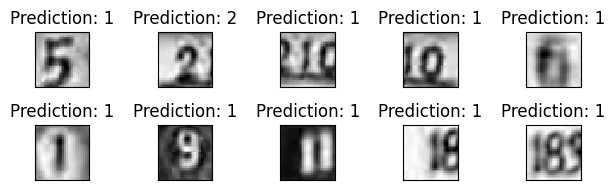

In [41]:
# Modellvorhersagen für die zuvor geladenen Beispielbilder berechnen
output = model(example_data)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# Zeige die ersten 10 Bilder und ihre Vorhersagen
for i in range(10):
    plt.subplot(5, 5, i+1)  # 5x5 Raster, aktueller Plot: i+1
    plt.tight_layout()      # Überlappungen vermeiden

    # Beispielbild anzeigen (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')

    # Vorhersage ermitteln:
    # max(1) → höchste Wahrscheinlichkeit entlang der Klassenachse
    # [1] → Index des Maximums → vorhergesagte Klasse
    predicted_label = output.data.max(1, keepdim=True)[1][i].item()

    # Titel mit der Vorhersage
    plt.title("Prediction: {}".format(predicted_label))

    # Achsen entfernen
    plt.xticks([])
    plt.yticks([])

# Plots anzeigen
plt.show()


## flexible CNN Struktur mit 5 Layern

In [112]:
def run_training(model, optimizer, train_loader, test_loader, n_epochs=3, exp_info=""):
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(1, n_epochs + 1):

        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        # ===== Testen =====
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        prefix = f"[{exp_info}] " if exp_info else ""
        print(f"{prefix}Epoch {epoch} | Test Acc: {accuracy:.2f}% | Test Loss: {test_loss:.4f}")

    return model, train_losses, test_losses, test_accuracies


### Definition
Flexible SVHN CNN mit 1–5 Convolutional Layers

Dieser Code definiert eine **flexible Convolutional Neural Network (CNN) Architektur für das SVHN-Dataset**, die zwischen 1 und 5 Convolutional Layers variieren kann.
Die Architektur umfasst:
- Mehrere Convolutional Layers mit ReLU-Aktivierungen
- Max-Pooling nach bestimmten Convs
- Spatial Dropout nach der letzten Convolution
- Fully Connected Layers für die Klassifikation in 10 Klassen (Ziffern 0–9)
- Log-Softmax am Output für die Nutzung mit `NLLLoss`


In [58]:
class SVHNC5NN(nn.Module):
    def __init__(
        self,
        num_conv_layers=5,   # Anzahl der Convolutional Layers, flexibel 1–5
        dropout_rate=0.3,    # Dropout-Wahrscheinlichkeit nach Convs
        fc_hidden=50         # Anzahl der Neuronen im Fully Connected Hidden Layer
    ):
        super().__init__()

        # Sicherstellen, dass num_conv_layers im erlaubten Bereich liegt
        assert 1 <= num_conv_layers <= 5, "num_conv_layers muss zwischen 1 und 5 liegen"
        self.num_conv_layers = num_conv_layers

        # --- Convolutional Layers ---
        # Erstellen einer flexiblen Liste von Conv-Layern
        self.convs = nn.ModuleList()
        in_channels = 3  # RGB-Bilder haben 3 Kanäle
        out_channels_list = [10, 20, 30, 40, 50]  # Ausgabekanäle pro Layer
        kernel_sizes = [5, 5, 3, 3, 3]           # Kernelgrößen pro Layer

        for i in range(num_conv_layers):
            # Conv Layer erstellen und zur Liste hinzufügen
            self.convs.append(nn.Conv2d(in_channels, out_channels_list[i], kernel_size=kernel_sizes[i]))
            in_channels = out_channels_list[i]

        # Dropout Layer nach dem letzten Conv
        self.dropout = nn.Dropout2d(p=dropout_rate)

        # --- Dummy Forward Pass ---
        # Berechnung der Flatten-Dimension automatisch
        dummy_input = torch.zeros(1, 3, 32, 32)  # 1 Dummy-Bild
        x = dummy_input
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x))
            # MaxPooling nach Layer 2 und 4 (optional)
            if i in [1, 3]:
                x = F.max_pool2d(x, 2)
        self.flatten_dim = x.numel()  # Anzahl der Features nach Flatten

        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(self.flatten_dim, fc_hidden)  # Hidden Layer
        self.fc2 = nn.Linear(fc_hidden, 10)               # Output Layer: 10 Klassen (Ziffern)

    def forward(self, x):
        # --- Convolutional Forward Pass ---
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x))
            if i in [1, 3]:
                x = F.max_pool2d(x, 2)  # Max-Pooling nach Layer 2 und 4

        # Dropout anwenden
        x = self.dropout(x)

        # Flatten für Fully Connected Layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Log-Softmax für NLLLoss
        return F.log_softmax(x, dim=1)


In [121]:
def run_training(model, optimizer, train_loader, test_loader, n_epochs=3, exp_info=""):
    """
    Führt Training + Testen über mehrere Epochen durch.
    Gibt zurück:
      - das trainierte Modell
      - train_loss pro Epoche
      - test_loss pro Epoche
      - train_accuracy pro Epoche
      - test_accuracy pro Epoche
    """
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(1, n_epochs + 1):
        # ===== Training =====
        model.train()
        correct_train = 0
        train_loss_epoch = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct_train += pred.eq(target).sum().item()

        train_loss_epoch /= len(train_loader.dataset)
        train_acc_epoch = 100. * correct_train / len(train_loader.dataset)

        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_acc_epoch)

        # ===== Test =====
        model.eval()
        test_loss_epoch = 0
        correct_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss_epoch += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct_test += pred.eq(target).sum().item()

        test_loss_epoch /= len(test_loader.dataset)
        test_acc_epoch = 100. * correct_test / len(test_loader.dataset)

        test_losses.append(test_loss_epoch)
        test_accuracies.append(test_acc_epoch)

        # Ausgabe
        prefix = f"[{exp_info}] " if exp_info else ""
        print(f"{prefix}Epoch {epoch} | "
              f"Train Acc: {train_acc_epoch:.2f}% | Train Loss: {train_loss_epoch:.4f} | "
              f"Test Acc: {test_acc_epoch:.2f}% | Test Loss: {test_loss_epoch:.4f}")

    # Alles zurückgeben, inklusive trainiertem Modell
    return model, train_losses, test_losses, train_accuracies, test_accuracies


In [122]:
ALL_MODELS = {}      # speichert die trainierten Modelle
ALL_RESULTS = {}     # speichert Losses & Accuracies pro Modell
EPOCHS = 10
learning_rates = [0.2, 0.1, 0.01]
batch_sizes = [32, 64, 128, 256]


### 1 Layer

In [123]:
NUM_CONV_LAYERS = 1
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=1, LR=0.2, B=32 =====
[L1_LR0.2_B32] Epoch 1 | Train Acc: 18.85% | Train Loss: 2.2398 | Test Acc: 19.59% | Test Loss: 2.2253
[L1_LR0.2_B32] Epoch 2 | Train Acc: 18.89% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2265
[L1_LR0.2_B32] Epoch 3 | Train Acc: 18.87% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2248
[L1_LR0.2_B32] Epoch 4 | Train Acc: 18.91% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2274
[L1_LR0.2_B32] Epoch 5 | Train Acc: 18.89% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2280
[L1_LR0.2_B32] Epoch 6 | Train Acc: 18.87% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2263
[L1_LR0.2_B32] Epoch 7 | Train Acc: 18.85% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2271
[L1_LR0.2_B32] Epoch 8 | Train Acc: 18.89% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2305
[L1_LR0.2_B32] Epoch 9 | Train Acc: 18.87% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2264
[L1_LR0.2_B32] Epoch 10 | 

### 2 Layer

In [124]:
NUM_CONV_LAYERS = 2
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=2, LR=0.2, B=32 =====
[L2_LR0.2_B32] Epoch 1 | Train Acc: 18.88% | Train Loss: 2.2395 | Test Acc: 19.59% | Test Loss: 2.2279
[L2_LR0.2_B32] Epoch 2 | Train Acc: 18.87% | Train Loss: 2.2389 | Test Acc: 19.59% | Test Loss: 2.2248
[L2_LR0.2_B32] Epoch 3 | Train Acc: 18.93% | Train Loss: 2.2388 | Test Acc: 19.59% | Test Loss: 2.2262
[L2_LR0.2_B32] Epoch 4 | Train Acc: 18.86% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2294
[L2_LR0.2_B32] Epoch 5 | Train Acc: 18.88% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2277
[L2_LR0.2_B32] Epoch 6 | Train Acc: 18.88% | Train Loss: 2.2394 | Test Acc: 19.59% | Test Loss: 2.2239
[L2_LR0.2_B32] Epoch 7 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2256
[L2_LR0.2_B32] Epoch 8 | Train Acc: 18.89% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2247
[L2_LR0.2_B32] Epoch 9 | Train Acc: 18.99% | Train Loss: 2.2368 | Test Acc: 19.59% | Test Loss: 2.2267
[L2_LR0.2_B32] Epoch 10 | 

### 3 Layer

In [125]:
NUM_CONV_LAYERS = 3
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=3, LR=0.2, B=32 =====
[L3_LR0.2_B32] Epoch 1 | Train Acc: 21.64% | Train Loss: 2.1801 | Test Acc: 19.59% | Test Loss: 2.2267
[L3_LR0.2_B32] Epoch 2 | Train Acc: 18.85% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2288
[L3_LR0.2_B32] Epoch 3 | Train Acc: 18.90% | Train Loss: 2.2395 | Test Acc: 19.59% | Test Loss: 2.2282
[L3_LR0.2_B32] Epoch 4 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2265
[L3_LR0.2_B32] Epoch 5 | Train Acc: 18.88% | Train Loss: 2.2394 | Test Acc: 19.59% | Test Loss: 2.2254
[L3_LR0.2_B32] Epoch 6 | Train Acc: 18.91% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2290
[L3_LR0.2_B32] Epoch 7 | Train Acc: 18.88% | Train Loss: 2.2390 | Test Acc: 19.59% | Test Loss: 2.2248
[L3_LR0.2_B32] Epoch 8 | Train Acc: 18.88% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2289
[L3_LR0.2_B32] Epoch 9 | Train Acc: 18.89% | Train Loss: 2.2390 | Test Acc: 19.59% | Test Loss: 2.2272
[L3_LR0.2_B32] Epoch 10 | 

### 4 Layer

In [135]:
NUM_CONV_LAYERS = 4
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=4, LR=0.2, B=32 =====
[L4_LR0.2_B32] Epoch 1 | Train Acc: 19.02% | Train Loss: 2.2382 | Test Acc: 19.59% | Test Loss: 2.2234
[L4_LR0.2_B32] Epoch 2 | Train Acc: 18.90% | Train Loss: 2.2394 | Test Acc: 19.59% | Test Loss: 2.2264
[L4_LR0.2_B32] Epoch 3 | Train Acc: 18.89% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2262
[L4_LR0.2_B32] Epoch 4 | Train Acc: 18.86% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2254
[L4_LR0.2_B32] Epoch 5 | Train Acc: 18.87% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2320
[L4_LR0.2_B32] Epoch 6 | Train Acc: 18.90% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2264
[L4_LR0.2_B32] Epoch 7 | Train Acc: 18.90% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2250
[L4_LR0.2_B32] Epoch 8 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2271
[L4_LR0.2_B32] Epoch 9 | Train Acc: 18.87% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2283
[L4_LR0.2_B32] Epoch 10 | 

### 5 Layer

In [136]:
NUM_CONV_LAYERS = 5
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Training MODEL: L={NUM_CONV_LAYERS}, LR={lr}, B={bs} =====")

        train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)

        model = SVHNC5NN(num_conv_layers=NUM_CONV_LAYERS)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        exp_name = f"L{NUM_CONV_LAYERS}_LR{lr}_B{bs}"

        trained_model, train_loss, test_loss, train_acc, test_acc = run_training(
            model, optimizer, train_loader_exp, test_loader,
            n_epochs=EPOCHS,
            exp_info=exp_name
        )

        # Modelle & Ergebnisse speichern
        ALL_MODELS[exp_name] = trained_model
        ALL_RESULTS[exp_name] = {
            "train_loss": train_loss,
            "test_loss": test_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "layers": NUM_CONV_LAYERS,
            "lr": lr,
            "batch": bs
        }

print(f"\n=== FERTIG: {NUM_CONV_LAYERS} Convolutional Layer ===")



===== Training MODEL: L=5, LR=0.2, B=32 =====
[L5_LR0.2_B32] Epoch 1 | Train Acc: 18.85% | Train Loss: 2.2396 | Test Acc: 19.59% | Test Loss: 2.2276
[L5_LR0.2_B32] Epoch 2 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2257
[L5_LR0.2_B32] Epoch 3 | Train Acc: 18.85% | Train Loss: 2.2392 | Test Acc: 19.59% | Test Loss: 2.2274
[L5_LR0.2_B32] Epoch 4 | Train Acc: 18.91% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2250
[L5_LR0.2_B32] Epoch 5 | Train Acc: 18.92% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2270
[L5_LR0.2_B32] Epoch 6 | Train Acc: 18.87% | Train Loss: 2.2391 | Test Acc: 19.59% | Test Loss: 2.2282
[L5_LR0.2_B32] Epoch 7 | Train Acc: 18.87% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2330
[L5_LR0.2_B32] Epoch 8 | Train Acc: 18.90% | Train Loss: 2.2393 | Test Acc: 19.59% | Test Loss: 2.2305
[L5_LR0.2_B32] Epoch 9 | Train Acc: 18.90% | Train Loss: 2.2390 | Test Acc: 19.59% | Test Loss: 2.2245
[L5_LR0.2_B32] Epoch 10 | 

## Visualisierung

In diesem Abschnitt wollen wir die eben durchlaufenen Modelle miteinander vergleichen. Dafür schauen wir uns zunächst einmal alle Ergebnisse an.

In [157]:
print(ALL_RESULTS)

{'L1_LR0.2_B32': {'train_loss': [2.2398405278645352, 2.239284572355014, 2.2391663970262767, 2.239199931702557, 2.2391920594144405, 2.2391592385326042, 2.23916620503711, 2.239310094514376, 2.2391904469703587, 2.2392153224408458], 'test_loss': [2.225345448034998, 2.226479540885264, 2.224783997632421, 2.2274268551259664, 2.228039511743322, 2.2263252118209715, 2.227063960946991, 2.2305244851420096, 2.2263534205342337, 2.2301431944858243], 'train_acc': [18.85144081794231, 18.89375759313103, 18.870551619640445, 18.911503337565012, 18.888297364074422, 18.87328173416875, 18.85144081794231, 18.89375759313103, 18.866456447847987, 18.89921782218764], 'test_acc': [19.587430854333128, 19.587430854333128, 19.587430854333128, 19.587430854333128, 19.587430854333128, 19.587430854333128, 19.587430854333128, 19.587430854333128, 19.587430854333128, 19.587430854333128], 'layers': 1, 'lr': 0.2, 'batch': 32}, 'L1_LR0.2_B64': {'train_loss': [2.0526346830002518, 1.6563534434025229, 1.7122249804809502, 1.659546

Sinnvoll wäre natürlich ein Dataframe, der die Anzahl der Layer, die learning Rates und die Batch-Sizes sowie die Ergebnisse der letzten Epoche eines jeden Experiments darstellt.

In [156]:
rows = []
for exp_name, res in ALL_RESULTS.items():
    rows.append({
        "layers": res["layers"],
        "learning_rate": res["lr"],
        "batch_size": res["batch"],
        "train_loss_last": res["train_loss"][-1],
        "train_acc_last": res["train_acc"][-1],
        "test_loss_last": res["test_loss"][-1],
        "test_acc_last": res["test_acc"][-1]
    })

df = pd.DataFrame(rows)
df

,layers,learning_rate,batch_size,train_loss_last,train_acc_last,test_loss_last,test_acc_last
0,1,0.20,32,2.239215,18.899218,2.230143,19.587431
1,1,0.20,64,1.595963,47.158633,1.591065,48.997388
2,1,0.20,128,1.063148,66.128834,1.309597,60.921174
3,1,0.20,256,0.787616,76.340827,1.037928,70.194376
4,1,0.10,32,1.342608,56.918793,1.496626,52.581438
5,1,0.10,64,0.836623,74.488445,0.962749,72.241856
6,1,0.10,128,0.659064,80.360921,0.726805,80.447142
7,1,0.10,256,0.620938,81.690487,0.795428,77.808082
8,1,0.01,32,0.552753,83.931911,0.659946,82.256454
9,1,0.01,64,0.567220,83.769469,0.654335,82.214198


im kommenden wollen wir alle Modelle nach deren Gleichheit gruppieren, um diese besser zu vergleichen

In [139]:
MODELS_BY_LAYER = {}
RESULTS_BY_LAYER = {}

MODELS_BY_LR = {}
RESULTS_BY_LR = {}

MODELS_BY_BATCH = {}
RESULTS_BY_BATCH = {}


In [140]:
for exp_name, result in ALL_RESULTS.items():

    layer = result["layers"]
    lr = result["lr"]
    bs = result["batch"]

    # ===== GROUP BY LAYER =====
    if layer not in MODELS_BY_LAYER:
        MODELS_BY_LAYER[layer] = {}
        RESULTS_BY_LAYER[layer] = {}

    MODELS_BY_LAYER[layer][exp_name] = ALL_MODELS[exp_name]
    RESULTS_BY_LAYER[layer][exp_name] = result

    # ===== GROUP BY LEARNING RATE =====
    if lr not in MODELS_BY_LR:
        MODELS_BY_LR[lr] = {}
        RESULTS_BY_LR[lr] = {}

    MODELS_BY_LR[lr][exp_name] = ALL_MODELS[exp_name]
    RESULTS_BY_LR[lr][exp_name] = result

    # ===== GROUP BY BATCH SIZE =====
    if bs not in MODELS_BY_BATCH:
        MODELS_BY_BATCH[bs] = {}
        RESULTS_BY_BATCH[bs] = {}

    MODELS_BY_BATCH[bs][exp_name] = ALL_MODELS[exp_name]
    RESULTS_BY_BATCH[bs][exp_name] = result


um jetzt z.B. alle Ergebnisse aller Modelle mit 3 Layern zu bekommen führt man folgendes aus

In [134]:
RESULTS_BY_LAYER[3]

{'L3_LR0.2_B32': {'train_loss': [2.1801227022809146,
   2.239284584471704,
   2.2394625643201587,
   2.2393172066144365,
   2.2394321517858935,
   2.239320669271896,
   2.2389990804021513,
   2.239325526364142,
   2.239049323310687,
   2.2392037588256954],
  'test_loss': [2.2266982025212134,
   2.2288316745441534,
   2.228157551946564,
   2.226500866086335,
   2.2254434294252214,
   2.2290047157301665,
   2.224790981377131,
   2.2288586177485956,
   2.22722809931656,
   2.226748112747108],
  'train_acc': [21.64025280860532,
   18.854170932470616,
   18.896487707659336,
   18.89921782218764,
   18.88010702048951,
   18.912868394829164,
   18.884202192281965,
   18.881472077753664,
   18.885567249546117,
   18.871916676904597],
  'test_acc': [19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128,
   19.587430854333128],
  'layers': 3,
  'lr'

In [159]:
import matplotlib.pyplot as plt

def plot_accuracy(RESULTS, layers=None, lrs=None, batches=None, mode="test", title=None):
    # Filterfunktion
    def match(res):
        if layers is not None and not isinstance(layers, (list, tuple)):
            layers_list = [layers]
        else:
            layers_list = layers
        if layers_list is not None and res["layers"] not in layers_list:
            return False
        if lrs is not None and res["lr"] not in lrs:
            return False
        if batches is not None and res["batch"] not in batches:
            return False
        return True

    # passende Modelle filtern
    selected = {name: res for name, res in RESULTS.items() if match(res)}
    if len(selected) == 0:
        print("⚠️ Keine Modelle entsprechen diesem Filter.")
        return

    plt.figure(figsize=(10,6))

    # Plot
    for name, res in selected.items():
        if mode == "train":
            y = [v/100 for v in res["train_acc"]]  # Umrechnung in [0,1]
            plt.plot(y, marker='o', linestyle='-', label=f"{name} (train)")

        elif mode == "test":
            y = [v/100 for v in res["test_acc"]]
            plt.plot(y, marker='x', linestyle='--', label=f"{name} (test)")

        elif mode == "both":
            y_train = [v/100 for v in res["train_acc"]]
            y_test  = [v/100 for v in res["test_acc"]]
            plt.plot(y_train, marker='o', linestyle='-', label=f"{name} (train)")
            plt.plot(y_test, marker='x', linestyle='--', label=f"{name} (test)")

        else:
            raise ValueError("mode muss 'train', 'test' oder 'both' sein")

    plt.xlabel("Epoche")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.title(title or "Accuracy über Epochen")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Plots der Test-Accuracies der verschiedenen Layer

#### 1 Layer

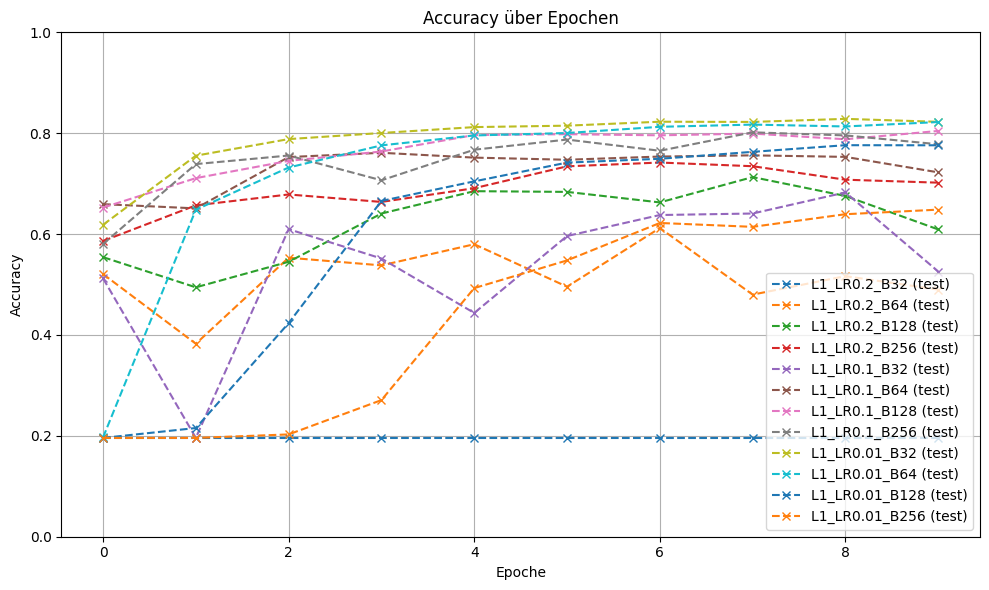

In [163]:
plot_accuracy(ALL_RESULTS, layers=[1], mode="test")   # nur Test Accuracy

#### 2 Layers

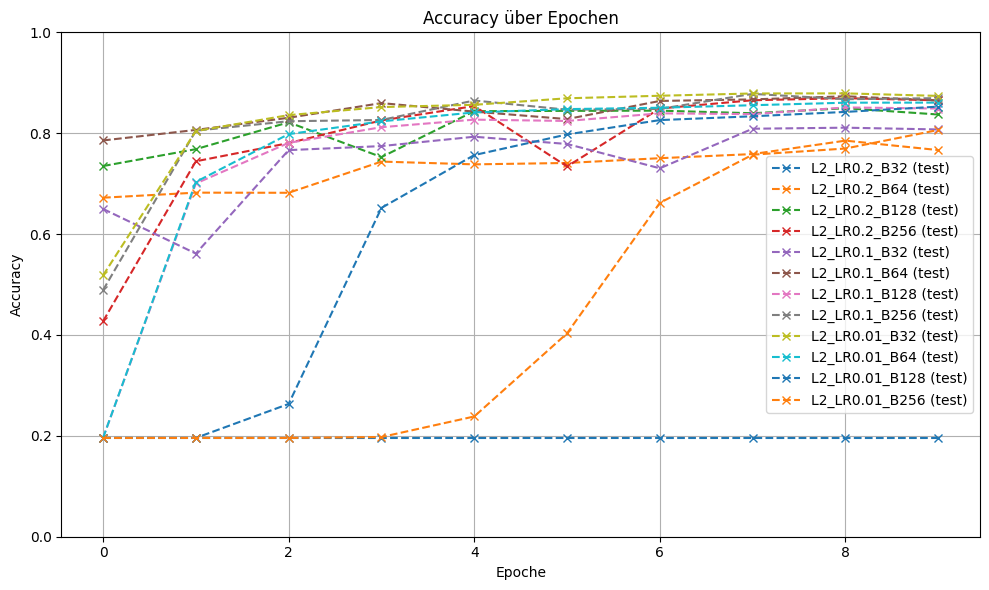

In [167]:
plot_accuracy(ALL_RESULTS, layers=[2], mode="test")   # nur Test Accuracy

#### 3 Layers

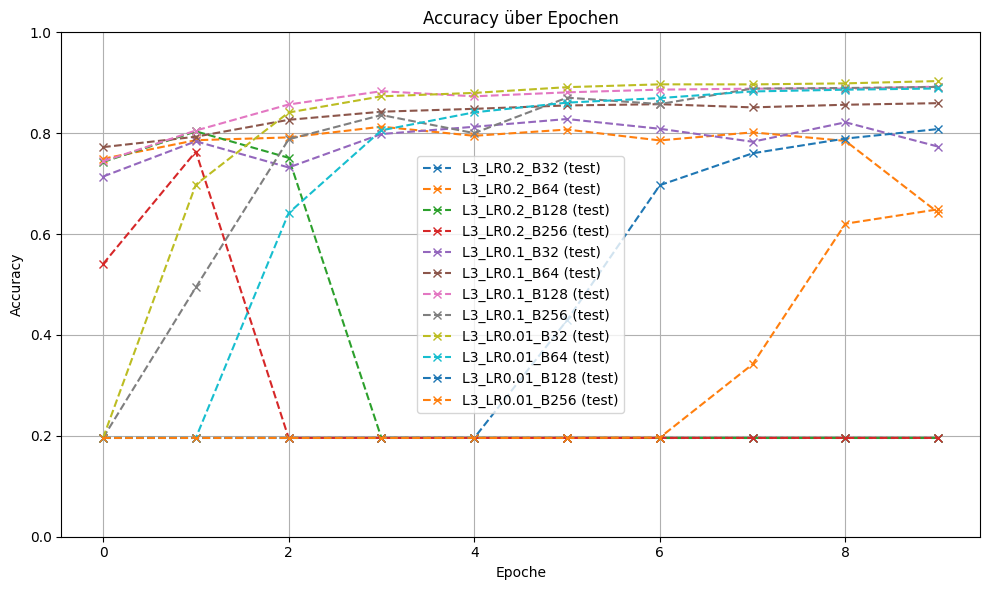

In [166]:
plot_accuracy(ALL_RESULTS, layers=[3], mode="test")   # nur Test Accuracy

#### 4 Layers

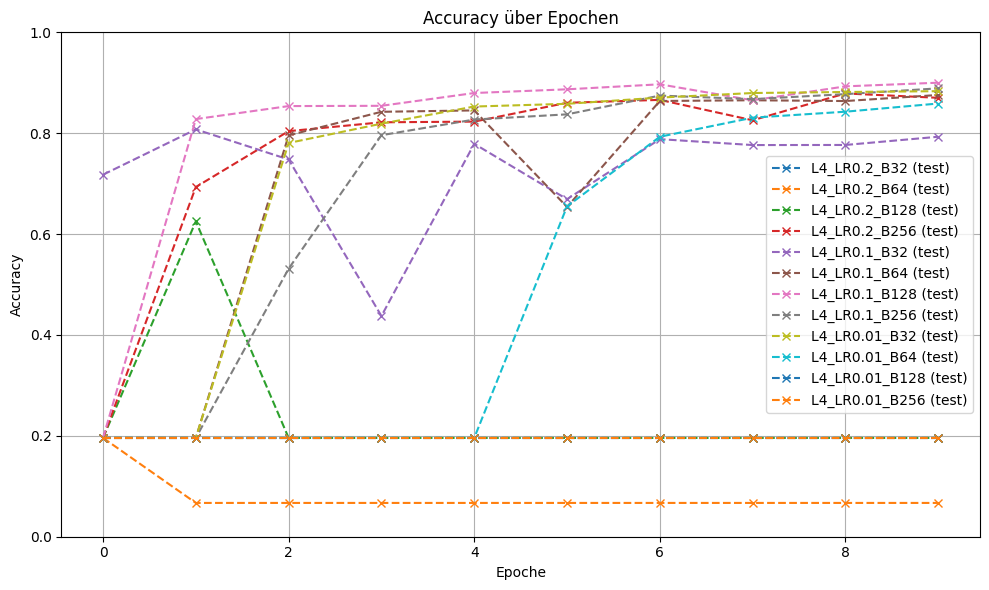

In [165]:
plot_accuracy(ALL_RESULTS, layers=[4], mode="test")   # nur Test Accuracy

#### 5 Layers

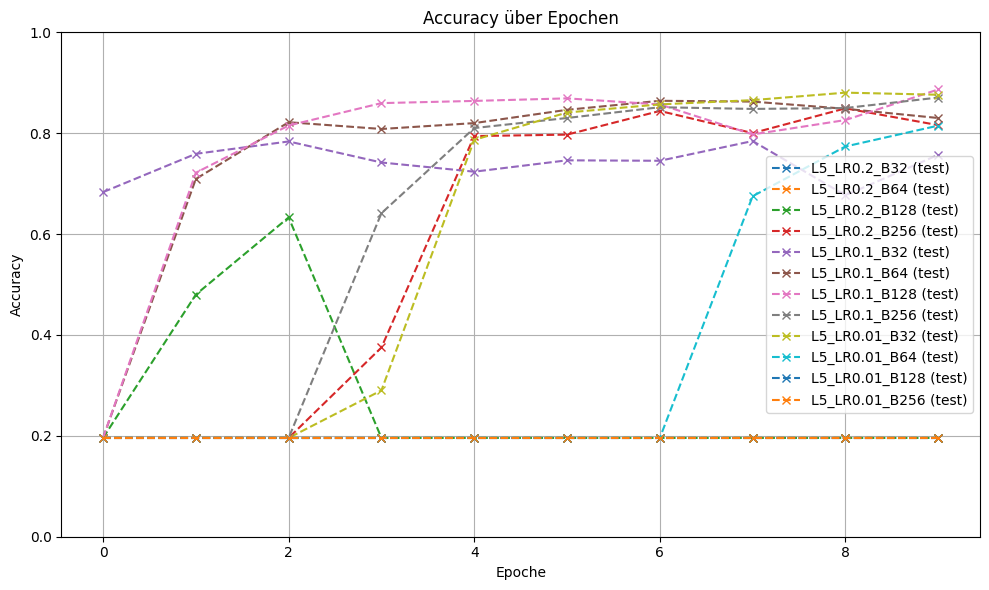

In [164]:
plot_accuracy(ALL_RESULTS, layers=[5], mode="test")   # nur Test Accuracy

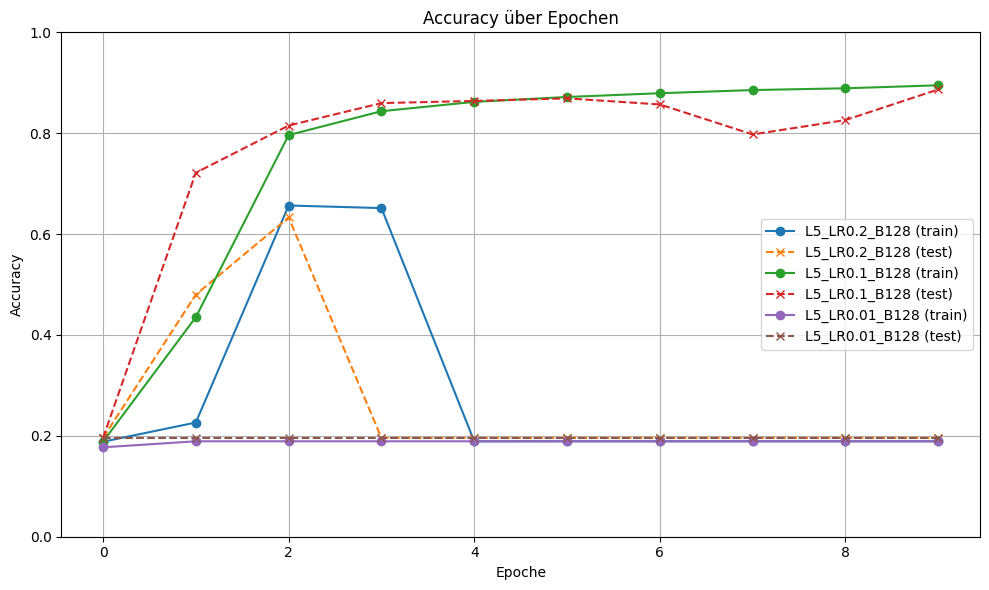

In [176]:
plot_accuracy(ALL_RESULTS, layers=5, batches=[128], mode="both")


#### erste Aussagen

Am vielversprechendsten sind auf dem ersten Blick die Modelle mit 128 Batches und einer learning rate von 0.1.

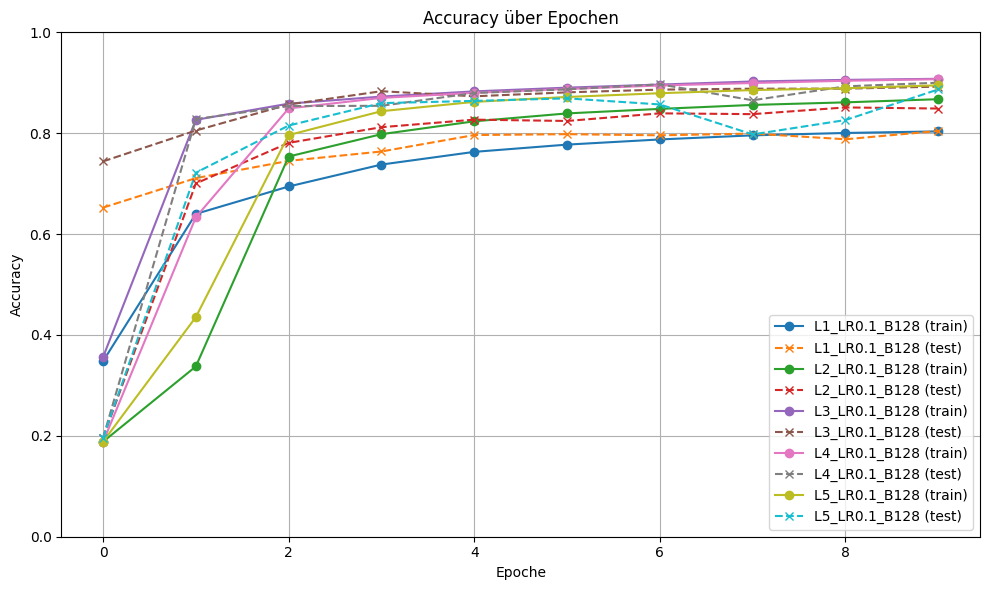

In [178]:
plot_accuracy(ALL_RESULTS, batches=[128], lrs =[0.1],mode="both")

Ganz im Gegenteil dazu mal 256 Batches und eine learning rate von 0.01. Dort werden gute Ergebnisse erst ab späterer Epochenzahl. Und 5 Layer können damit gar nicht trainiert werden.

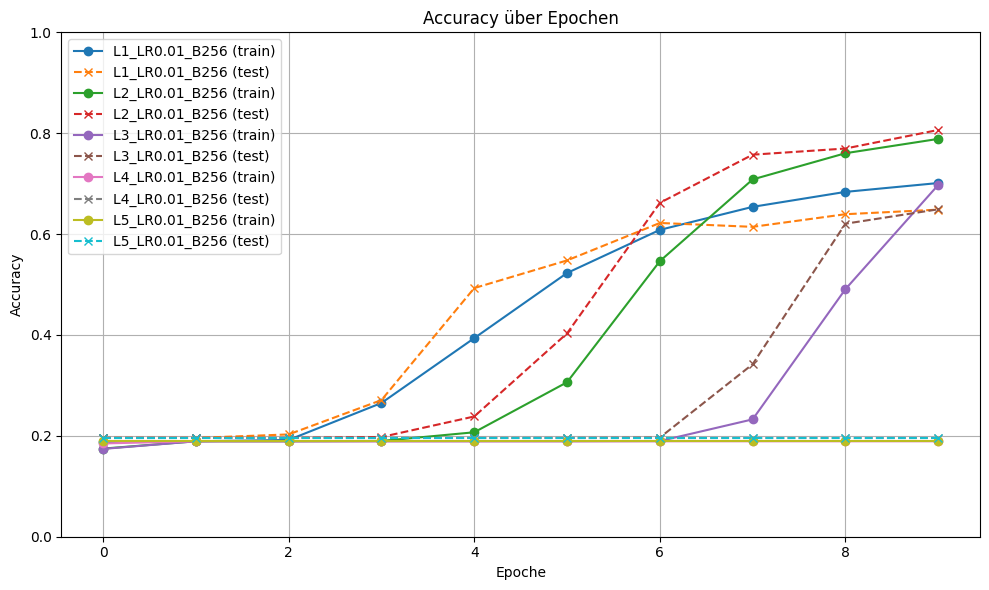

In [179]:
plot_accuracy(ALL_RESULTS, batches=[256], lrs =[0.01],mode="both")

Der andere Extremfall ist mit geringster Batchanzahl und höchster learning rate.

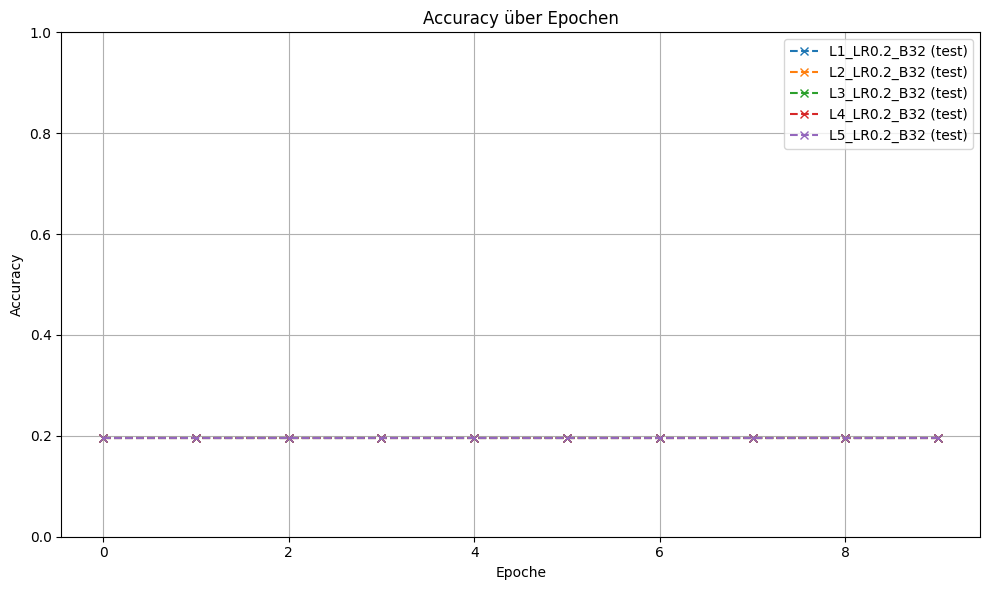

In [185]:
plot_accuracy(ALL_RESULTS, batches=[32], lrs = [0.2], mode="test")

dagegen passen geringe batches und geringe learning rate ganz gut zusammen, sowie hohe batch zahl mit hoher learning rate (außer bei drei Layern).

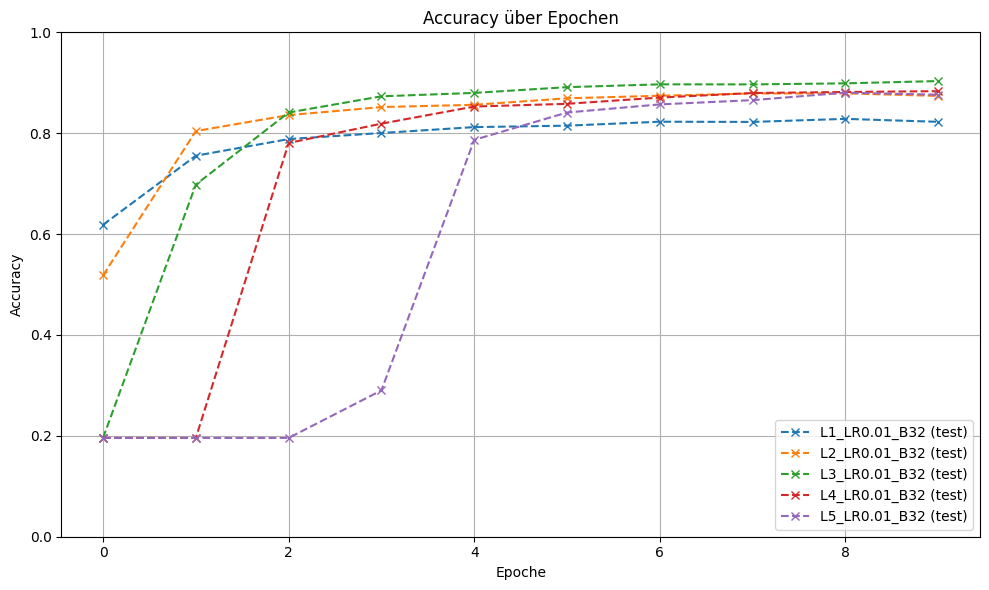

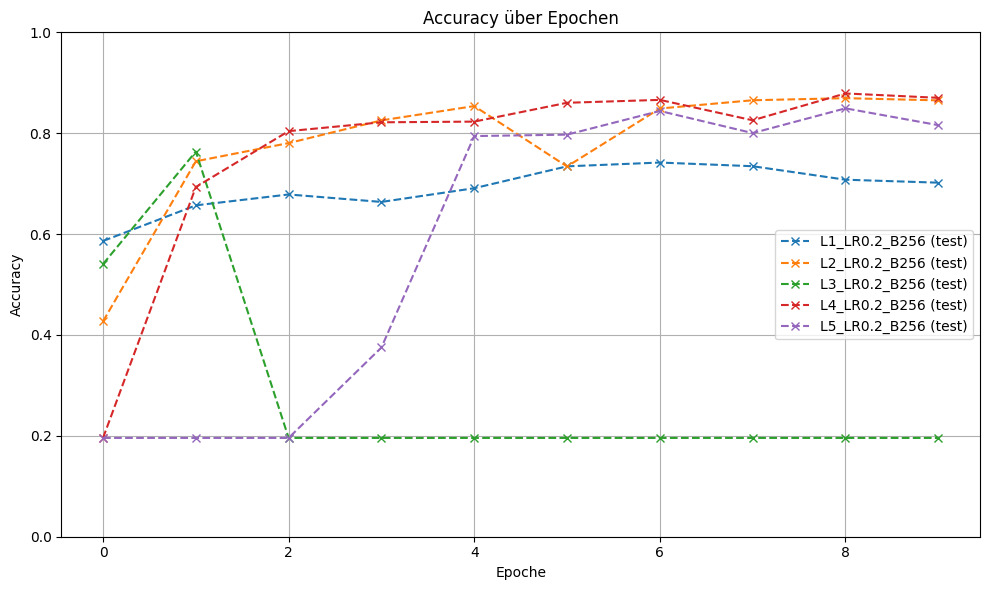

In [189]:
plot_accuracy(ALL_RESULTS, batches=[32], lrs = [0.01], mode="test")
plot_accuracy(ALL_RESULTS, batches=[256], lrs = [0.2], mode="test")

### ausgewählte Modelle vergleichen

Wir betrachten also folglich nur noch die Modelle mit einer learning rate von 0.1 und einer batch zahl von 128 oder 256.

#### Confusion Matrix

In [193]:
def compute_predictions_for_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in test_loader:
            logits = model(x)
            preds = logits.argmax(dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred


In [194]:
for name, model in ALL_MODELS.items():

    print(f"📥 Generiere Predictions für {name} ...")

    y_true, y_pred = compute_predictions_for_model(model, test_loader)

    ALL_RESULTS[name]["y_true"] = y_true
    ALL_RESULTS[name]["y_pred"] = y_pred

print("\n✅ Alle Modelle haben jetzt y_true und y_pred gespeichert!")


📥 Generiere Predictions für L1_LR0.2_B32 ...
📥 Generiere Predictions für L1_LR0.2_B64 ...
📥 Generiere Predictions für L1_LR0.2_B128 ...
📥 Generiere Predictions für L1_LR0.2_B256 ...
📥 Generiere Predictions für L1_LR0.1_B32 ...
📥 Generiere Predictions für L1_LR0.1_B64 ...
📥 Generiere Predictions für L1_LR0.1_B128 ...
📥 Generiere Predictions für L1_LR0.1_B256 ...
📥 Generiere Predictions für L1_LR0.01_B32 ...
📥 Generiere Predictions für L1_LR0.01_B64 ...
📥 Generiere Predictions für L1_LR0.01_B128 ...
📥 Generiere Predictions für L1_LR0.01_B256 ...
📥 Generiere Predictions für L2_LR0.2_B32 ...
📥 Generiere Predictions für L2_LR0.2_B64 ...
📥 Generiere Predictions für L2_LR0.2_B128 ...
📥 Generiere Predictions für L2_LR0.2_B256 ...
📥 Generiere Predictions für L2_LR0.1_B32 ...
📥 Generiere Predictions für L2_LR0.1_B64 ...
📥 Generiere Predictions für L2_LR0.1_B128 ...
📥 Generiere Predictions für L2_LR0.1_B256 ...
📥 Generiere Predictions für L2_LR0.01_B32 ...
📥 Generiere Predictions für L2_LR0.01_B6

In [197]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_for(name):
    res = ALL_RESULTS[name]
    y_true = res["y_true"]
    y_pred = res["y_pred"]

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Confusion Matrix für die verschiedenen Layer bei lr= 0.1 und batch= 128

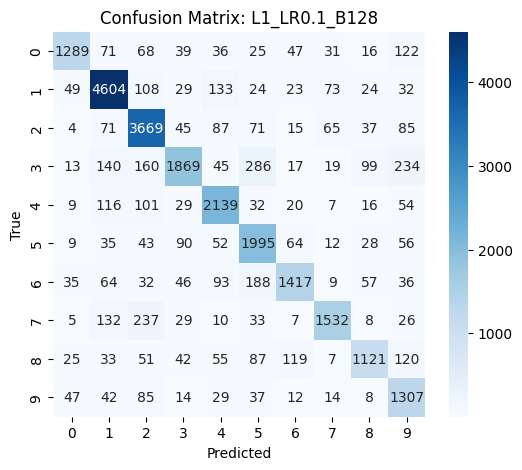

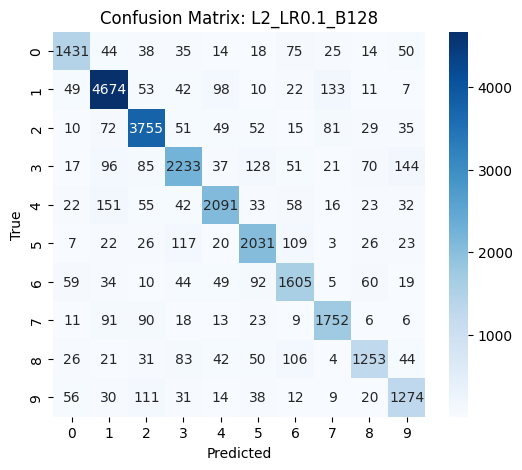

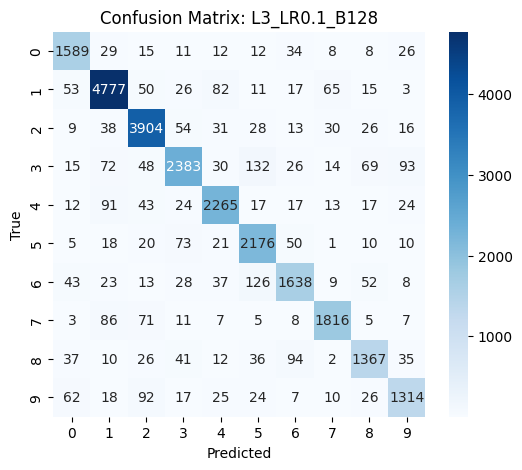

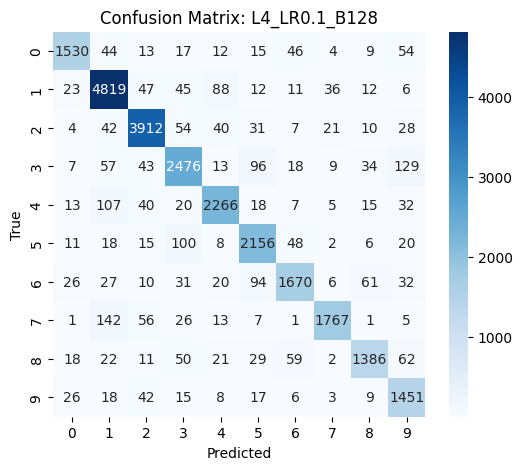

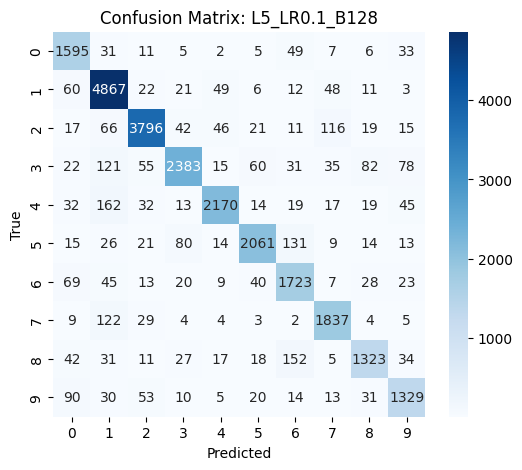

In [198]:
for name, res in ALL_RESULTS.items():
    if res["lr"] == 0.1 and res["batch"] == 128:
        plot_confusion_for(name)


#### metriken

In [199]:
from sklearn.metrics import classification_report

def metrics_for_models(ALL_RESULTS, lr=None, batch=None):
    """
    Gibt Precision / Recall / F1-Scores für alle Modelle mit bestimmter
    Learning Rate und Batch Size aus.
    """

    for name, res in ALL_RESULTS.items():

        # Filter anwenden
        if lr is not None and res["lr"] != lr:
            continue
        if batch is not None and res["batch"] != batch:
            continue

        # Predictions prüfen
        if "y_true" not in res or "y_pred" not in res:
            print(f"⚠️ {name} hat keine gespeicherten y_true/y_pred — übersprungen.")
            continue

        y_true = res["y_true"]
        y_pred = res["y_pred"]

        print(f"\n==============================")
        print(f"📊 METRIKEN FÜR MODELL: {name}")
        print(f"==============================")

        print(classification_report(
            y_true, y_pred,
            digits=4  # schönere Formatierung
        ))


In [200]:
metrics_for_models(ALL_RESULTS, lr=0.1, batch=128)



📊 METRIKEN FÜR MODELL: L1_LR0.1_B128
              precision    recall  f1-score   support

           0     0.8680    0.7391    0.7984      1744
           1     0.8674    0.9029    0.8848      5099
           2     0.8057    0.8843    0.8432      4149
           3     0.8374    0.6485    0.7309      2882
           4     0.7984    0.8478    0.8224      2523
           5     0.7181    0.8368    0.7730      2384
           6     0.8139    0.7167    0.7622      1977
           7     0.8660    0.7588    0.8089      2019
           8     0.7928    0.6753    0.7293      1660
           9     0.6308    0.8194    0.7128      1595

    accuracy                         0.8045     26032
   macro avg     0.7998    0.7830    0.7866     26032
weighted avg     0.8105    0.8045    0.8034     26032


📊 METRIKEN FÜR MODELL: L2_LR0.1_B128
              precision    recall  f1-score   support

           0     0.8477    0.8205    0.8339      1744
           1     0.8928    0.9167    0.9046      5099
  

#### Output Daten: Vergleich zwischen Vorhersagen und tatsächlichen Werten

hier das mit den Bildern erstellen. nutze dafür am besten die definierten
ALL_RESULTS[name]["y_true"] = y_true
ALL_RESULTS[name]["y_pred"] = y_pred